In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.rcParams['axes.unicode_minus'] = False # 顯示負號

In [2]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_val_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')
word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_val_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')
bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_val_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

In [3]:
def train_xgboost_model(df, model_path, scaler_path):
    data = df.copy()
    y = data.pop('source')

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.values)

    joblib.dump(scaler, scaler_path)

    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Grid Search
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 200, 300]
    }

    # XGBoost model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        device = 'cuda'
    )
    model.fit(X_train, y_train)

    
    joblib.dump(model, model_path)

    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(cm_train, annot=True, fmt='d', ax=ax[0], cmap='Blues')
    ax[0].set_title('Train Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    sns.heatmap(cm_test, annot=True, fmt='d', ax=ax[1], cmap='Blues')
    ax[1].set_title('Test Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')

    plt.show()

    return model, scaler

In [4]:
def evaluate_on_new_data(model, scaler, new_data):
    data = new_data.copy()
    y_new = data.pop('source')
    X_new_scaled = scaler.transform(data.values)

    
    y_pred_new = model.predict(X_new_scaled)

    new_f2 = fbeta_score(y_new, y_pred_new, beta=2)
    cm_new = confusion_matrix(y_new, y_pred_new)

    print(f'New Data F2 Score: {new_f2:.4f}')

    # confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on New Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [22:13:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


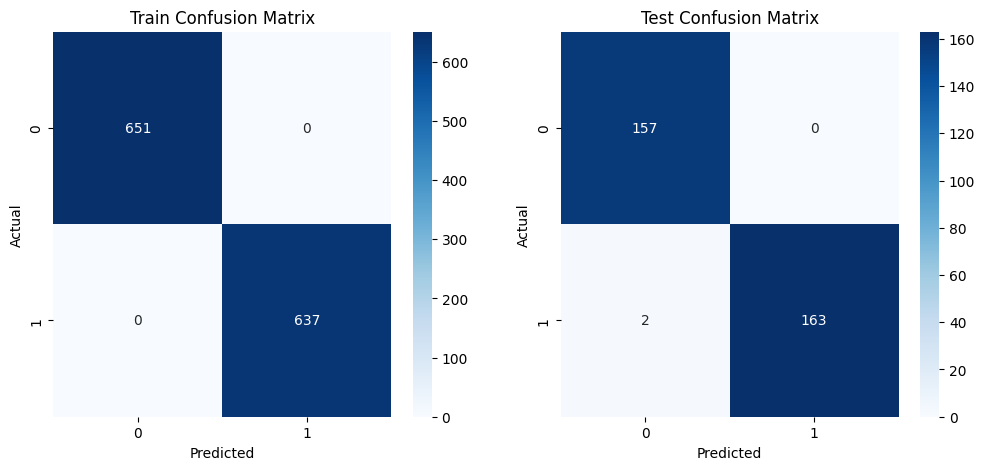

New Data F2 Score: 0.9951


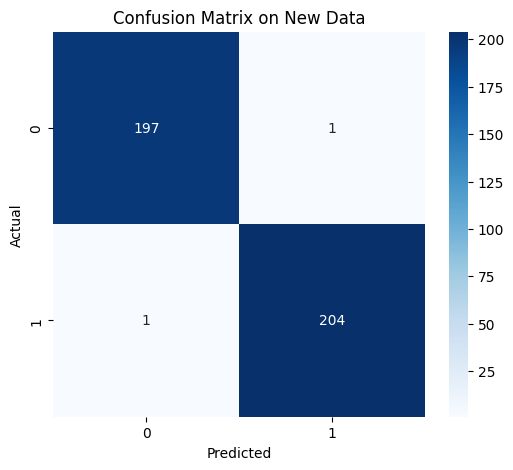

In [5]:
model, scaler = train_xgboost_model(tfidf_train_data, '../Data/Model/tfidf_xgboost_model.pkl', '../Data/Model/tfidf_scaler.pkl')
evaluate_on_new_data(model, scaler, tfidf_val_data)


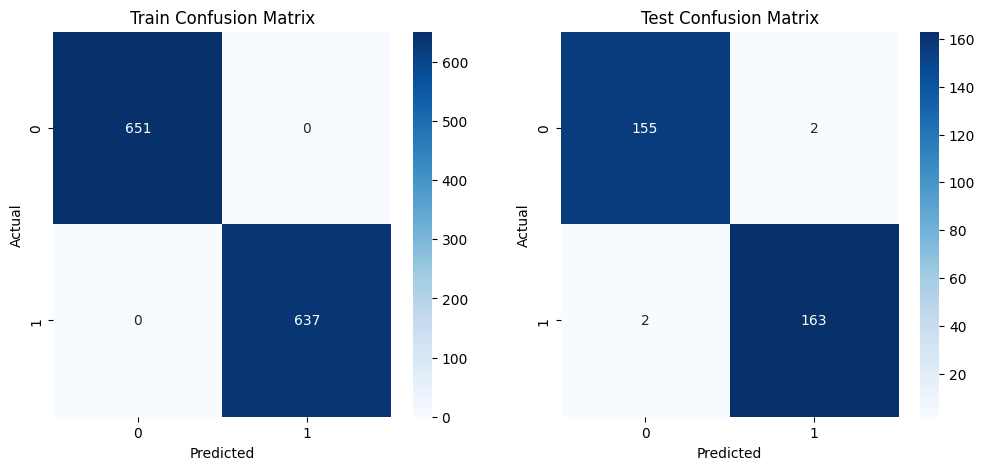

New Data F2 Score: 0.9677


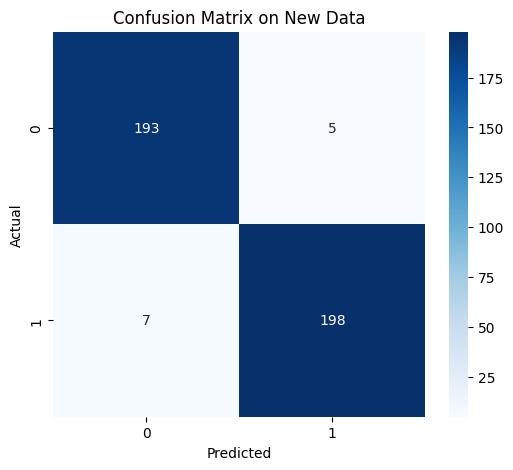

In [6]:
model, scaler = train_xgboost_model(word2vec_train_data, '../Data/Model/word2vec_xgboost_model.pkl', '../Data/Model/word2vec_scaler.pkl')
evaluate_on_new_data(model, scaler, word2vec_val_data)

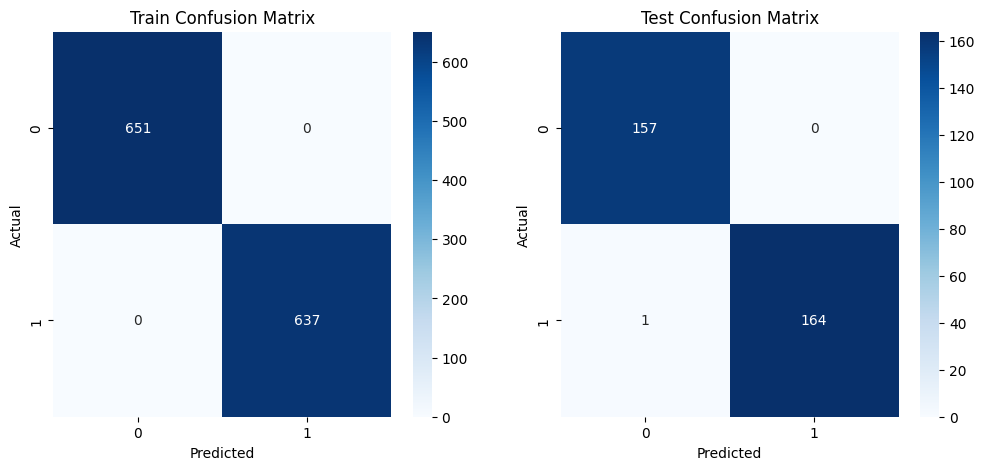

New Data F2 Score: 0.9951


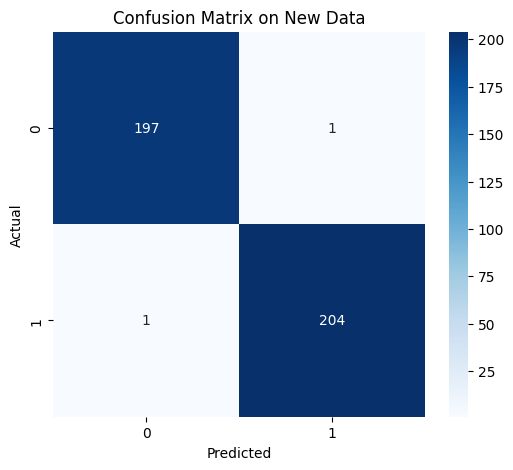

In [7]:
model, scaler = train_xgboost_model(bert_train_data, '../Data/Model/bert_xgboost_model.pkl', '../Data/Model/bert_scaler.pkl')
evaluate_on_new_data(model, scaler, bert_val_data)